# Simple constrained maximum area problem with linear and nonlinear constraints solved using **SCIPY** and **Pyomo**

In [1]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
  !wget -O basic_material.py https://www.dropbox.com/s/3aoexl8vxyitmds/basic_material.py?dl=0
%run basic_material

try:
    import google.colab
    IN_COLAB = True
    # don't need serial here
except:
    IN_COLAB = False
    try: 
        import serial
    except:
        !pip3 install pyserial
        import serial

import time, csv, os, requests
 
from os import path
if os.path.isdir("./data/"):
    pass
else:
    !mkdir ./data
    
if os.path.isdir("./figs/"):
    pass
else:
    !mkdir ./figs

Running Python: 3.9.9


/Users/jonathanhow/myenv/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


**Problem**: With positive $x$ and $y$, maximize area of a rectangle ($A = xy$) subject to
1.   linear constraint that perimeter length $2(x+y) \leq Perim$  
2.   Nonlinear constraint that $y \leq Peak -x^2$


In [2]:
Perim = 20
Peak = 17

In [3]:
sx, sy = sym.symbols(['sx','sy'])
fun = sx*sy # area
numfun = sym.lambdify((sx, sy),fun) # ftn
gradfun = [sym.diff(fun,var) for var in (sx, sy)] #take the gradient symbolically wrt x
numgradfun = sym.lambdify((sx, sy),gradfun) #turn into a bivariate lambda for numpy

# function
def farea(X):
    x,y = X
    return -numfun(x,y) # to maximize
  
# NL Constraint
def cons_f(X):
    x,y = X
    return y + x**2 - Peak # y \leq Peak - x^2

In [4]:
# NL constraint
nonlinear_constraint = NonlinearConstraint(cons_f, -np.inf, 0) # inequality UB of zero

# Linear constraint 
A = np.array([2,2]) # 2(x+y)
lin_cons = LinearConstraint(A,0,Perim)
bounds = Bounds([0, 0], [np.inf, np.inf]) # both positive numbers

x0 = np.array([2.3, Peak-2**2]) # initial condition

sol_lin = minimize(farea,x0,constraints=lin_cons, bounds=bounds, method='trust-constr', options={'xtol': 1e-12, 'gtol': 1e-12, 'disp': True, 'verbose':1})
sol_NL = minimize(farea, x0, method='trust-constr', bounds=bounds, constraints=[nonlinear_constraint],options={'disp': True, 'verbose':0})

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 45, CG iterations: 21, optimality: 3.65e-15, constraint violation: 0.00e+00, execution time: 0.039 s.
`gtol` termination condition is satisfied.
Number of iterations: 23, function evaluations: 42, CG iterations: 23, optimality: 1.24e-15, constraint violation: 0.00e+00, execution time: 0.026 s.


In [5]:
print(f'\nLinear Constrained solution: x = {sol_lin.x[0]:.3f} and y = {sol_lin.x[1]:.3f}')
print('Max Linear area = ', round(sol_lin.x[0]*sol_lin.x[1],3))

if (sol_lin.v[0] > 0): # (see 2-13 in notes)
    print('Linear constraint active with margin: '+str(A@sol_lin.x-Perim))

print(f'\nExpected solution: x = {np.sqrt(Peak/3):.3f} and y = {Peak*2/3:.3f}')
print('Expected area = ', round(Peak*2/3*np.sqrt(Peak/3),3))
print(f'\nNL Constrained solution: x = {sol_NL.x[0]:.3f} and y = {sol_NL.x[1]:.3f}')
print('Max Nonlinear area = ', round(sol_NL.x[0]*sol_NL.x[1],3))

if (sol_NL.v[0] > 0):
    print('NL constraint active with margin: '+str(np.format_float_positional(round(cons_f(sol_NL.x),10))))


Linear Constrained solution: x = 5.000 and y = 5.000
Max Linear area =  25.0
Linear constraint active with margin: -2.5600006594572733e-06

Expected solution: x = 2.380 and y = 11.333
Expected area =  26.979

NL Constrained solution: x = 2.380 and y = 11.333
Max Nonlinear area =  26.979
NL constraint active with margin: -0.0000000215


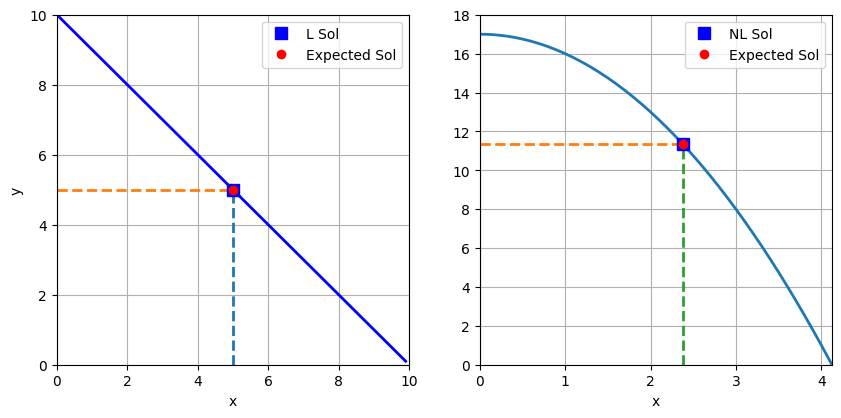

In [6]:
# set up the figure
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan = 1)

X = np.arange(0,Perim/2,.1)

ax1.plot(X,(Perim-2*X)/2,'b-')
ax1.set_ylim([0,10])
ax1.set_xlim([0,10])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.plot([sol_lin.x[0], sol_lin.x[0]],[0,sol_lin.x[1]],'--')
ax1.plot([0, sol_lin.x[0]],[sol_lin.x[1], sol_lin.x[1]],'--')
ax1.plot(sol_lin.x[0],sol_lin.x[1],'bs',ms=8,label='L Sol')
ax1.plot(Perim/4,(Perim-2*Perim/4)/2,'ro',label='Expected Sol') # expected solution
ax1.legend()
#ax1.set_aspect('equal')
ax2.plot(X,-cons_f(np.array([X, 0*X])))
ax2.plot([0, sol_NL.x[0]],[sol_NL.x[1], sol_NL.x[1]],'--')
ax2.plot([sol_NL.x[0], sol_NL.x[0]],[0,sol_NL.x[1]],'--')
ax2.plot(sol_NL.x[0],sol_NL.x[1],'bs',ms=8,label='NL Sol')
ax2.plot(np.sqrt(Peak/3),2*Peak/3,'ro',label='Expected Sol') # expected solution
ax2.legend()
ax2.set_ylim([0,Peak+1])
ax2.set_xlim([0,np.sqrt(Peak)])
#ax2.set_aspect('equal')
ax2.set_xlabel('x')
#ax2.set_ylabel('y')
plt.show()

## Try same problems using Pyomo

In [15]:
if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *

**Pyomo Solution: linear**

In [22]:
# create a model instance
m = ConcreteModel()

# create the decision variable
m.x = Var(domain=NonNegativeReals)
m.y = Var(domain=NonNegativeReals)

m.cons = Constraint(rule=lambda m: 2*(m.x+m.y) <= Perim) # Perim constraint

# create the objective
m.area = Objective(expr=m.x*m.y, sense=maximize)

#m.pprint()
# solve using the nonlinear solver ipopt
SolverFactory('ipopt').solve(m)

print('Linear sol x = ', round(m.x(),3) ,'and y = ',round(m.y(),3))
print('Max area = ', round(m.area(),3))
print('Constraint Margin = ', round(m.cons() - Perim,3))

Linear sol x =  5.0 and y =  5.0
Max area =  25.0
Constraint Margin =  0.0


**Pyomo Solution: nonlinear**

In [23]:
# create a model instance
m2 = ConcreteModel()

# create the decision variable
m2.x = Var(domain=NonNegativeReals)
m2.y = Var(domain=NonNegativeReals)

m2.cons = Constraint(rule=lambda m2: m2.y <= Peak - m2.x**2) # y \leq Peak - x^2

# create the objective
m2.area = Objective(expr=m2.x*m2.y, sense=maximize)

#m2.pprint()
# solve using the nonlinear solver ipopt
SolverFactory('ipopt').solve(m2)

print(f'\nExpected solution: x = {np.sqrt(Peak/3):.3f} and y = {Peak*2/3:.3f}')
print(f'Nonlinear solution: x = {m2.x():.3f} and y = {m2.y():.3f}')
print('Max area = ', round(m2.area(),3))
print('Constraint Margin = ', round(m2.cons(),3))


Expected solution: x = 2.380 and y = 11.333
Nonlinear solution: x = 2.380 and y = 11.333
Max area =  26.979
Constraint Margin =  0.0
